In [1]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 20.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: n

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
from torch.utils.data import DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

COLOR_MAP = {
    (0, 0, 0): 0,        # background
    (255, 0, 0): 1,      # red = fibrin
    (0, 255, 0): 2,      # green = granulation
    (0, 0, 255): 3       # blue = callus
}

def rgb_to_label(mask):
    """Convert RGB mask → label mask"""
    mask = np.array(mask)
    h, w, _ = mask.shape
    label = np.zeros((h, w), dtype=np.int64)
    
    for rgb, cls in COLOR_MAP.items():
        label[(mask == rgb).all(axis=2)] = cls

    return label


class MultiClassWoundDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Chargement des images
        img = Image.open(img_path).convert("RGB")
        mask_rgb = Image.open(mask_path).convert("RGB")

        # Resize uniquement ici
        if self.img_transform:
            img = self.img_transform(img)

        if self.mask_transform:
            mask_rgb = self.mask_transform(mask_rgb)

        # Conversion RGB → label classes après resize
        mask = rgb_to_label(mask_rgb)
        mask = torch.tensor(mask, dtype=torch.long)

        return img, mask


In [4]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST)
])

In [5]:
train_dataset = MultiClassWoundDataset(
    "/kaggle/input/wound-data/Images/TrainVal",
    "/kaggle/input/wound-data/Palette/TrainVal",
    img_transform,
    mask_transform
)

test_dataset = MultiClassWoundDataset(
    "/kaggle/input/wound-data/Images/Test",
    "/kaggle/input/wound-data/Palette/Test",
    img_transform,
    mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [6]:
import torch

# Vérifie si un GPU est dispo, sinon utilise le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [7]:
binary_model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights=None,
    in_channels=3,
    classes=1
)

binary_model.load_state_dict(torch.load("best_one.pth"))


<All keys matched successfully>

In [8]:
multi_model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights=None,   # pas imagenet, on utilise tes poids
    in_channels=3,
    classes=4
)

In [9]:
# Copier tous les poids SAUF la dernière couche de classification
pretrained_dict = binary_model.state_dict()
model_dict = multi_model.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}

model_dict.update(pretrained_dict)
multi_model.load_state_dict(model_dict)
multi_model = multi_model.to(device)

In [10]:
# === LOSSES ===
criterion_dice = smp.losses.DiceLoss(
    mode="multiclass",
    from_logits=True
)

criterion_focal = smp.losses.FocalLoss(
    mode="multiclass",
    gamma=2
)

weights = torch.tensor([0.1, 3.0, 1.0, 1.5]).to(device)
criterion_ce = torch.nn.CrossEntropyLoss(weight=weights)

# === COMBINED LOSS ===
def combined_loss(logits, masks):
    loss_dice  = criterion_dice(logits, masks)
    loss_focal = criterion_focal(logits, masks)
    loss_ce_   = criterion_ce(logits, masks)
    return 0.5 * loss_dice + 0.3 * loss_focal + 0.2 * loss_ce_


In [11]:
for param in multi_model.encoder.parameters():
    param.requires_grad = False


In [12]:
optimizer = torch.optim.Adam([
    {"params": multi_model.decoder.parameters(), "lr": 0.001},
    {"params": multi_model.segmentation_head.parameters(), "lr": 0.001}
])


In [13]:
import torch
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy, MulticlassJaccardIndex, MulticlassF1Score

WARMUP_EPOCHS = 4
print("🔥 Starting WARM-UP phase...\n")

for epoch in range(1, WARMUP_EPOCHS + 1):
    multi_model.train()
    total_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Warm-up Epoch {epoch}/{WARMUP_EPOCHS}"):
        imgs, masks = imgs.to(device), masks.to(device)

        logits = multi_model(imgs)
        loss = combined_loss(logits, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Warm-up Epoch {epoch} | Loss: {total_loss/len(train_loader):.4f}")


🔥 Starting WARM-UP phase...



Warm-up Epoch 1/4: 100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


Warm-up Epoch 1 | Loss: 0.6417


Warm-up Epoch 2/4: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Warm-up Epoch 2 | Loss: 0.4997


Warm-up Epoch 3/4: 100%|██████████| 24/24 [00:06<00:00,  3.64it/s]


Warm-up Epoch 3 | Loss: 0.4597


Warm-up Epoch 4/4: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]

Warm-up Epoch 4 | Loss: 0.4510


In [14]:
for param in multi_model.encoder.parameters():
    param.requires_grad = True


In [15]:
optimizer = torch.optim.Adam(multi_model.parameters(), lr=3e-5)

In [16]:


# --- METRIQUES MULTICLASSES ---
num_classes = 4  # 0:bg, 1,2,3 = tissues

metric_acc  = MulticlassAccuracy(num_classes=num_classes).to(device)
metric_iou  = MulticlassJaccardIndex(num_classes=num_classes).to(device)
metric_dice = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)

# --- OPTIMIZER ---
optimizer = torch.optim.Adam(multi_model.parameters(), lr=0.0001)

# --- LEARNING RATE SCHEDULER ---
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,        # divise LR par 2
    patience=2,         # si val_loss ne baisse pas pendant 2 epochs
    verbose=True
)

# --- EARLY STOPPING ---
best_val_loss = float("inf")
patience = 7
early_stop_counter = 0

In [17]:
EPOCHS = 4

print("🚀 Starting training...\n")

for epoch in range(1, EPOCHS + 1):
    multi_model.train()   # <-- CORRECT
    train_loss = 0.0
    train_acc = 0.0
    train_iou = 0.0
    train_dice = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        # --- Forward ---
        logits = multi_model(imgs)

        # --- Losses ---
        loss_dice  = criterion_dice(logits, masks)
        loss_focal = criterion_focal(logits, masks)
        loss_ce    = criterion_ce(logits, masks)
        
        loss = 0.5 * loss_dice + 0.3 * loss_focal + 0.2 * loss_ce

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_acc  += metric_acc(preds, masks).item()
        train_iou  += metric_iou(preds, masks).item()
        train_dice += metric_dice(preds, masks).item()

    train_loss /= len(train_loader)
    train_acc  /= len(train_loader)
    train_iou  /= len(train_loader)
    train_dice /= len(train_loader)

    # ============================
    #       VALIDATION
    # ============================
    multi_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_iou = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            logits = multi_model(imgs)   # <-- CORRECT

            loss_dice  = criterion_dice(logits, masks)
            loss_focal = criterion_focal(logits, masks)
            loss_ce    = criterion_ce(logits, masks)
            loss = 0.5 * loss_dice + 0.3 * loss_focal + 0.2 * loss_ce

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            val_acc  += metric_acc(preds, masks).item()
            val_iou  += metric_iou(preds, masks).item()
            val_dice += metric_dice(preds, masks).item()

    val_loss /= len(val_loader)
    val_acc  /= len(val_loader)
    val_iou  /= len(val_loader)
    val_dice /= len(val_loader)

    scheduler.step(val_loss)

    print(f"\n📊 Epoch {epoch}/{EPOCHS}")
    print(f"   🔵 Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou:.4f} | Dice: {train_dice:.4f}")
    print(f"   🟢  Val  Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

    # --- EARLY STOPPING ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0

        # SAUVEGARDE CORRECTE
        torch.save(multi_model.state_dict(), "best_multiclass_model.pth")
        print("   💾 Saved new best model!")

    else:
        early_stop_counter += 1
        print(f"   ⏳ Early stopping patience: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("\n🛑 Early stopping triggered. Training stopped.")
            break


🚀 Starting training...




📊 Epoch 1/4
   🔵 Train Loss: 0.4286 | Acc: 0.7182 | IoU: 0.4988 | Dice: 0.6334
   🟢  Val  Loss: 0.3186 | Acc: 0.7555 | IoU: 0.6087 | Dice: 0.7139
   💾 Saved new best model!



📊 Epoch 2/4
   🔵 Train Loss: 0.3900 | Acc: 0.7547 | IoU: 0.5262 | Dice: 0.6571
   🟢  Val  Loss: 0.3139 | Acc: 0.7465 | IoU: 0.6149 | Dice: 0.7258
   💾 Saved new best model!



📊 Epoch 3/4
   🔵 Train Loss: 0.3616 | Acc: 0.7802 | IoU: 0.5547 | Dice: 0.6840
   🟢  Val  Loss: 0.2811 | Acc: 0.7743 | IoU: 0.6352 | Dice: 0.7355
   💾 Saved new best model!



📊 Epoch 4/4
   🔵 Train Loss: 0.3494 | Acc: 0.7765 | IoU: 0.5584 | Dice: 0.6811
   🟢  Val  Loss: 0.2849 | Acc: 0.7669 | IoU: 0.6446 | Dice: 0.7456
   ⏳ Early stopping patience: 1/7


In [18]:
multi_model.load_state_dict(torch.load("best_multiclass_model.pth", map_location=device))
multi_model.to(device)
multi_model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [19]:
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MulticlassJaccardIndex,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall
)

num_classes = 4  # background + 3 tissus

acc_metric  = MulticlassAccuracy(num_classes=num_classes).to(device)
iou_metric  = MulticlassJaccardIndex(num_classes=num_classes).to(device)
dice_metric = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)
prec_metric = MulticlassPrecision(num_classes=num_classes, average="macro").to(device)
rec_metric  = MulticlassRecall(num_classes=num_classes, average="macro").to(device)


In [20]:
import torch
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()

    total_loss = 0
    total_acc = 0
    total_iou = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    count = 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating")

        for imgs, masks in loop:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = multi_model(imgs)
            preds = torch.argmax(logits, dim=1)

            # Metrics
            total_acc       += acc_metric(preds, masks).item()
            total_iou       += iou_metric(preds, masks).item()
            total_dice      += dice_metric(preds, masks).item()
            total_precision += prec_metric(preds, masks).item()
            total_recall    += rec_metric(preds, masks).item()

            count += 1

    results = {
        "accuracy":   total_acc / count,
        "iou":        total_iou / count,
        "dice":       total_dice / count,
        "precision":  total_precision / count,
        "recall":     total_recall / count
    }

    return results


In [21]:
results = evaluate_model(multi_model, val_loader, device)

print("\n===== ÉVALUATION DU MODÈLE =====")
print(f"Accuracy      : {results['accuracy']:.4f}")
print(f"IoU (macro)   : {results['iou']:.4f}")
print(f"Dice (macro)  : {results['dice']:.4f}")
print(f"Precision     : {results['precision']:.4f}")
print(f"Recall        : {results['recall']:.4f}")

Evaluating: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


===== ÉVALUATION DU MODÈLE =====
Accuracy      : 0.7743
IoU (macro)   : 0.6352
Dice (macro)  : 0.7355
Precision     : 0.7263
Recall        : 0.7743


In [22]:
dice_per_class = MulticlassF1Score(num_classes=4, average=None).to(device)
iou_per_class  = MulticlassJaccardIndex(num_classes=4, average=None).to(device)

def evaluate_per_class(model, dataloader):
    model.eval()
    dice_sum = torch.zeros(4).to(device)
    iou_sum = torch.zeros(4).to(device)
    count = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)

            dice_sum += dice_per_class(preds, masks)
            iou_sum += iou_per_class(preds, masks)
            count += 1

    return (dice_sum / count).cpu(), (iou_sum / count).cpu()

dice_cls, iou_cls = evaluate_per_class(multi_model, val_loader)

print("\n===== PAR CLASSE =====")
print(f"Background : Dice {dice_cls[0]:.4f} | IoU {iou_cls[0]:.4f}")
print(f"Fibrin     : Dice {dice_cls[1]:.4f} | IoU {iou_cls[1]:.4f}")
print(f"Granulation: Dice {dice_cls[2]:.4f} | IoU {iou_cls[2]:.4f}")
print(f"Callus     : Dice {dice_cls[3]:.4f} | IoU {iou_cls[3]:.4f}")



===== PAR CLASSE =====
Background : Dice 0.9201 | IoU 0.8526
Fibrin     : Dice 0.4009 | IoU 0.3027
Granulation: Dice 0.8952 | IoU 0.8148
Callus     : Dice 0.7258 | IoU 0.5709


In [23]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_predictions(model, dataset, device, n=10):
    model.eval()
    plt.figure(figsize=(15, n * 3))

    for i in range(n):
        img, mask = dataset[i]                # mask : [H,W] classes
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_in)
            pred = torch.argmax(logits, dim=1)[0].cpu()

        # convert to numpy
        img_np = img.permute(1, 2, 0).cpu().numpy()

        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(img_np)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(mask, cmap="jet")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(pred, cmap="jet")
        plt.title("Masque prédit")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


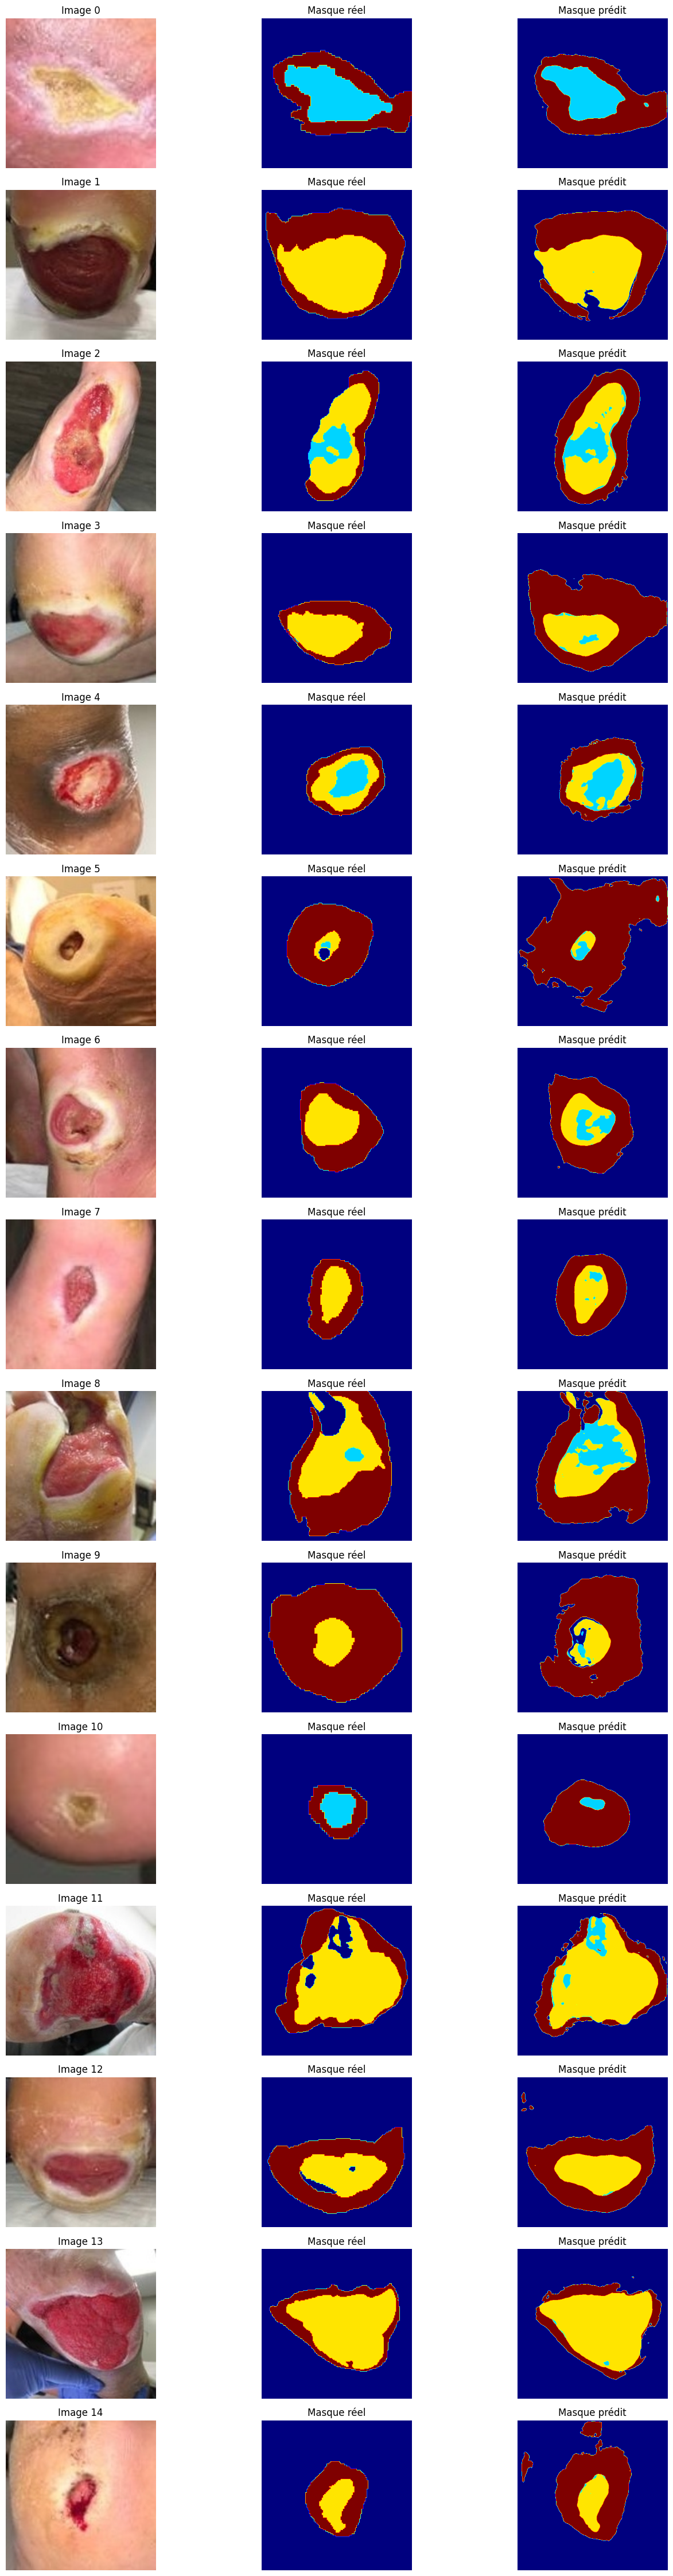

In [24]:
show_predictions(multi_model, test_dataset, device, n=15)

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from datetime import datetime

def save_predictions(model, dataset, device, n=10, save_dir="./predictions"):
    """Sauvegarde uniquement les masques prédits"""
    # Créer le répertoire de sauvegarde
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    for i in range(min(n, len(dataset))):  # Limiter à la taille du dataset
        img, _ = dataset[i]  # On ne récupère que l'image, pas besoin du masque réel
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_in)
            pred = torch.argmax(logits, dim=1)[0].cpu()

        # Convertir en numpy array
        pred_np = pred.numpy()
        
        # Option 1: Sauvegarder en PNG avec matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(pred_np, cmap="jet")
        plt.axis("off")
        plt.tight_layout()
        
        save_path = os.path.join(save_dir, f"pred_mask_{i:03d}.png")
        plt.savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        # Option 2: Sauvegarder en numpy array (format natif)
        # np.save(os.path.join(save_dir, f"pred_mask_{i:03d}.npy"), pred_np)
        
        # Option 3: Sauvegarder avec pillow (plus léger)
        # from PIL import Image
        # pred_image = Image.fromarray((pred_np * 255 / pred_np.max()).astype(np.uint8))
        # pred_image.save(os.path.join(save_dir, f"pred_mask_{i:03d}.png"))
        
        print(f"Masque prédit sauvegardé: {save_path}")
    
    print(f"\nTous les masques prédits ont été sauvegardés dans: {save_dir}")

# Version alternative avec paramètre optionnel pour inclure les images originales
def save_only_predicted_masks(model, dataset, device, n=10, save_dir="./predicted_masks", 
                             include_images=False, save_format="png"):
    """Sauvegarde uniquement les masques prédits, avec option pour les images"""
    os.makedirs(save_dir, exist_ok=True)
    
    model.eval()
    
    for i in range(min(n, len(dataset))):
        if include_images:
            img, _ = dataset[i]
        else:
            # Si on n'a pas besoin de l'image, on peut la charger quand même pour la prédiction
            img, _ = dataset[i]
        
        img_in = img.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(img_in)
            pred = torch.argmax(logits, dim=1)[0].cpu()

        pred_np = pred.numpy()
        
        # Créer une figure plus petite pour juste le masque
        plt.figure(figsize=(6, 6))
        plt.imshow(pred_np, cmap="jet")
        plt.axis("off")
        plt.tight_layout()
        
        # Sauvegarder selon le format spécifié
        if save_format.lower() == "png":
            save_path = os.path.join(save_dir, f"mask_{i:03d}.png")
            plt.savefig(save_path, dpi=100, bbox_inches='tight', pad_inches=0)
        elif save_format.lower() == "jpg":
            save_path = os.path.join(save_dir, f"mask_{i:03d}.jpg")
            plt.savefig(save_path, dpi=100, bbox_inches='tight', pad_inches=0, 
                       format='jpg', quality=95)
        
        plt.close()
        
        print(f"Masque {i} sauvegardé: {save_path}")
    
    print(f"\nTous les {n} masques prédits ont été sauvegardés dans: {save_dir}")

# Utilisation de la fonction simplifiée
save_predictions(multi_model, test_dataset, device, n=15, save_dir="./predicted_masks")

# Ou utilisation de la version avancée
# save_only_predicted_masks(multi_model, test_dataset, device, n=15, 
#                          save_dir="./masks", save_format="png")

Masque prédit sauvegardé: ./predicted_masks/pred_mask_000.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_001.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_002.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_003.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_004.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_005.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_006.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_007.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_008.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_009.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_010.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_011.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_012.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_013.png
Masque prédit sauvegardé: ./predicted_masks/pred_mask_014.png

Tous les masques prédits ont été sauvegardés dans: ./predicted_masks


**XAI_Segmentation_Multiple**

In [5]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.1 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 116.5 MB/s eta 0:00:0000:010:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d6fe592ae21710c022be5850f0d17c30a6751c76067794c5d84b657f941b2e54
  Stored in dire

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
multi_model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights=None,
    in_channels=3,
    classes=4
).to(device)

multi_model.load_state_dict(torch.load("/kaggle/input/multi-segmentation/tensorflow2/default/1/best_multiclass_model (1).pth", map_location=device))
multi_model.eval()


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [9]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])


In [49]:
img_path = "/kaggle/input/wound-data/Images/TrainVal/0910.png"  # <-- change si besoin

img = Image.open(img_path).convert("RGB")
img_tensor = img_transform(img).unsqueeze(0).to(device)

img_np = img_tensor[0].permute(1,2,0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())


In [50]:
with torch.no_grad():
    logits = multi_model(img_tensor)
    preds = torch.argmax(logits, dim=1)[0].cpu().numpy()


In [51]:
target_layers = [multi_model.encoder.layer4[-1]]


In [52]:
class SegmentationTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        # model_output shape: [C, H, W]
        return model_output[self.category, :, :].mean()


In [53]:
target_layers = [multi_model.encoder.layer4[-1]]

class SegmentationTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        return model_output[self.category, :, :].mean()


In [54]:
from pytorch_grad_cam import GradCAM

cam = GradCAM(
    model=multi_model,
    target_layers=target_layers
)

class_names = ["Background", "Fibrin", "Granulation", "Callus"]

cams = {}

for class_idx in range(1, 4):
    targets = [SegmentationTarget(class_idx)]

    grayscale_cam = cam(
        input_tensor=img_tensor,
        targets=targets
    )

    cams[class_idx] = grayscale_cam[0]  # (H, W)


In [55]:
for k, v in cams.items():
    print(k, v.shape, v.min(), v.max())


1 (512, 512) 0.0 0.9999999
2 (512, 512) 0.0 0.9999999
3 (512, 512) 0.0 0.9999999


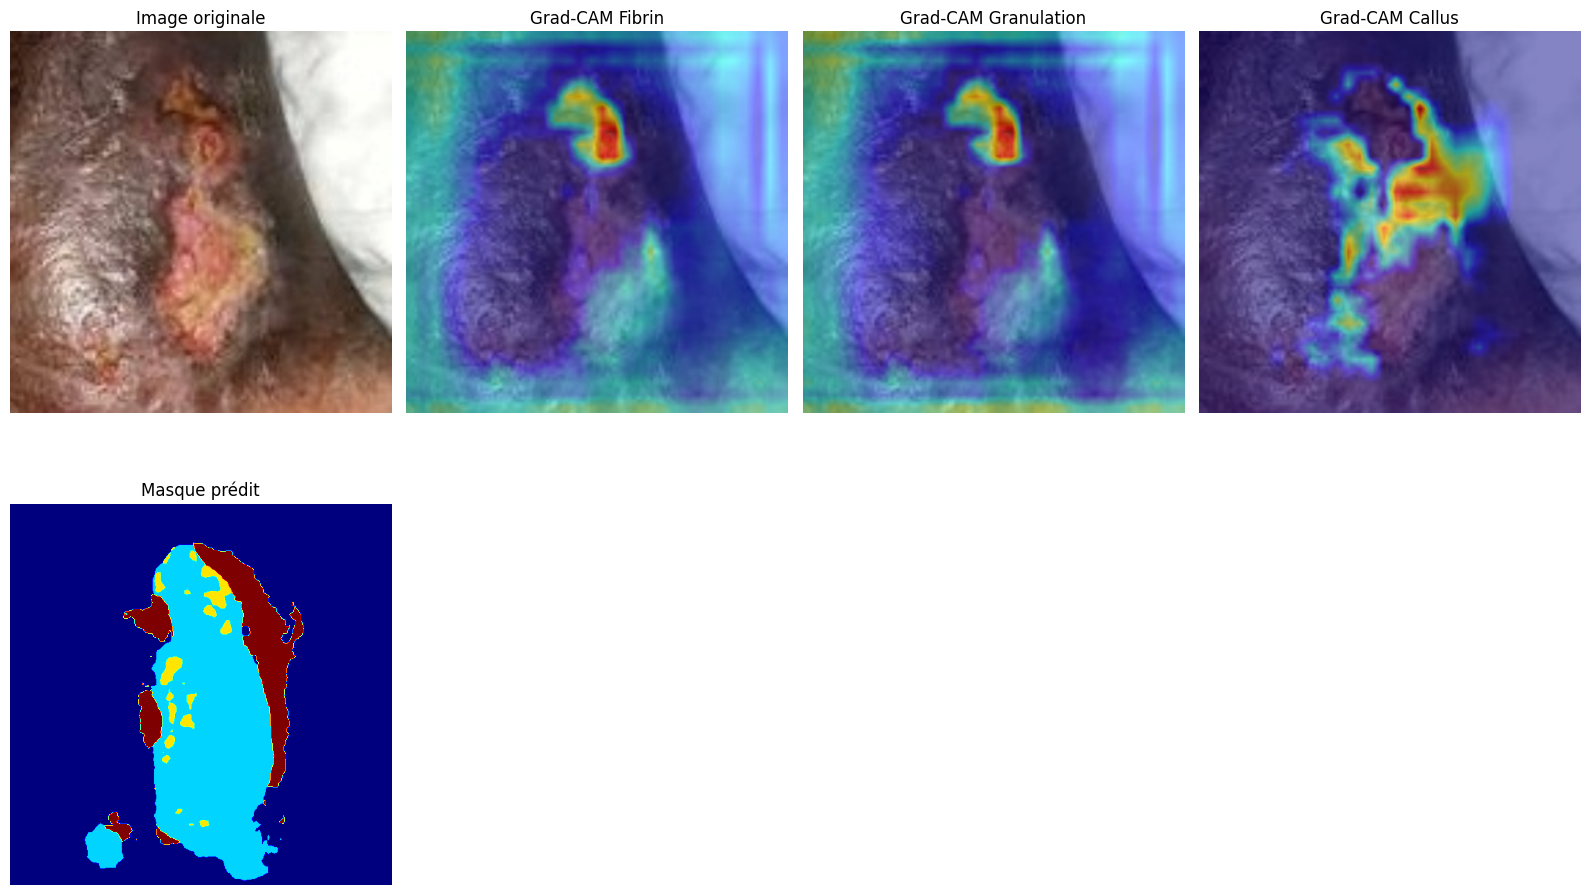

In [56]:
plt.figure(figsize=(16,10))

# Image originale
plt.subplot(2,4,1)
plt.imshow(img_np)
plt.title("Image originale")
plt.axis("off")

# Masque prédit
plt.subplot(2,4,5)
plt.imshow(preds, cmap="jet")
plt.title("Masque prédit")
plt.axis("off")

# Grad-CAM par classe
for i, class_idx in enumerate(range(1,4)):
    cam_img = show_cam_on_image(img_np, cams[class_idx], use_rgb=True)

    plt.subplot(2,4,i+2)
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM {class_names[class_idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


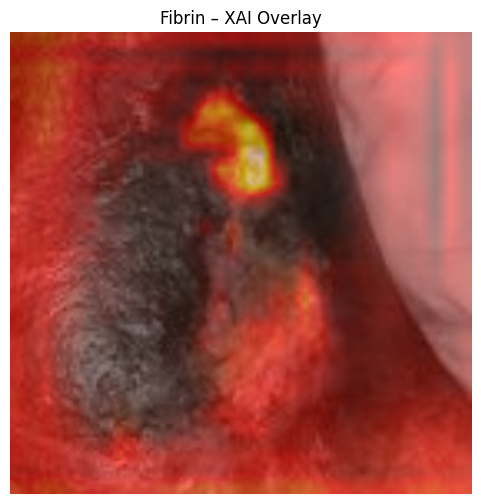

In [57]:
plt.figure(figsize=(6,6))
plt.imshow(img_np)
plt.imshow(cams[1], cmap="hot", alpha=0.5)
plt.title("Fibrin – XAI Overlay")
plt.axis("off")
plt.show()
